In [ ]:
!git clone https://github.com/lseventeen/RF-UNet.git


Cloning into 'RF-UNet'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 147 (delta 60), reused 125 (delta 49), pack-reused 3
Receiving objects: 100% (147/147), 281.78 MiB | 13.20 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Updating files: 100% (22/22), done.


In [16]:
#!pip install albumentations
!pip install bunch
!pip install loguru
#!pip install matplotlib
#!pip install numpy
#!pip3 install opencv_python
#!pip install Pillow
!pip install ruamel.base
#!pip install scikit_learn
!pip install segmentation
!pip install timm
#!pip install torch
!pip install torchstat
#!pip install torchvision
!pip install tqdm
!pip install ttach
!pip install yacs

In [17]:
!pip install ruamel.yaml

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
import argparse
import pickle
import cv2
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
from PIL import Image
from ruamel.yaml import YAML
from torchvision.transforms import Grayscale, Normalize, ToTensor
import sys
sys.path.append('/content/drive/MyDrive/EIMproject/FR')
from utils.helpers import dir_exists, remove_files
from tqdm import tqdm

In [19]:
def normalization(imgs_list):
  #concatena i tensori
    imgs = torch.cat(imgs_list, dim=0)
  #prendi il valore medio e std
    mean = torch.mean(imgs)
    std = torch.std(imgs)

    normal_list = []
    for i in imgs_list:
      #normalizzo elemento per elemento
      #standardizzazione su media e std di tutte le immagini
        n = Normalize([mean], [std])(i)
      #min max per la singola immagine standardizzata
        n = (n - torch.min(n)) / (torch.max(n) - torch.min(n))
        normal_list.append(n)
    return normal_list

# def get_patch(imgs_list, patch_size, stride):
#     image_list = []
#   #prendi altezza e larhezza della immagine
#     _, h, w = imgs_list[0].shape
#   #determinazione del padding necessario:
#   # % è l'operatore che mi da il resto di una operazione
#     pad_h = stride - (h - patch_size) % stride
#     pad_w = stride - (w - patch_size) % stride
#   #
#     for sub1 in tqdm(imgs_list):
#       #applicazione del padding alla immagine
#         image = F.pad(sub1, (0, pad_w, 0, pad_h), "constant", 0)
#       #suddivisione in patch
#       ##Chat GPT: permute riorganizza l'ordine delle dimensioni in modo che le
#       ##dimensioni corrispondenti a 1 e 2 (altezza e larghezza delle patch)
#       ##vengano spostate all'inizio (dimensioni 0 e 1),
#       ##mentre le altre dimensioni potrebbero essere riorganizzate di conseguenza.
#         image = image.unfold(1, patch_size, stride).unfold(
#             2, patch_size, stride).permute(1, 2, 0, 3, 4)
#       ##La chiamata a contiguous() è utilizzata per garantire che il tensore
#       ##abbia un layout di memoria contiguo prima di applicare la funzione view()
#       ## Un tensore è contiguo quando i suoi elementi sono memorizzati
#       ##in modo continuo in memoria senza salti o frammentazioni
#         image = image.contiguous().view(
#             image.shape[0] * image.shape[1], image.shape[2], patch_size, patch_size)
#       #iterazione di sotto crea una lista di patch
#         for sub2 in image:
#             image_list.append(sub2)
#     return image_list #NB la lista contiene le PATCH


def get_patch(imgs, patch_size, stride):
    patch_to_save = []
  #prendi altezza e larhezza della immagine
    _,h, w = (imgs).shape
    #print(h)
  #determinazione del padding necessario:
  # % è l'operatore che mi da il resto di una operazione
    pad_h = stride - (h - patch_size) % stride
    pad_w = stride - (w - patch_size) % stride
  #
    #print(pad_h)
    # for sub1 in tqdm(imgs):
      #applicazione del padding alla immagine
    if stride==pad_h:
      pad_h=0
    if stride==pad_w:
       pad_w=0
    image = F.pad(imgs, (0, pad_w, 0, pad_h), "constant", 0)
      #suddivisione in patch
      ##Chat GPT: permute riorganizza l'ordine delle dimensioni in modo che le
      ##dimensioni corrispondenti a 1 e 2 (altezza e larghezza delle patch)
      ##vengano spostate all'inizio (dimensioni 0 e 1),
      ##mentre le altre dimensioni potrebbero essere riorganizzate di conseguenza.
    image = image.unfold(1, patch_size, stride).unfold(2, patch_size, stride).permute(1, 2, 0, 3, 4)
    #print(image.shape)
      ##La chiamata a contiguous() è utilizzata per garantire che il tensore
      ##abbia un layout di memoria contiguo prima di applicare la funzione view()
      ## Un tensore è contiguo quando i suoi elementi sono memorizzati
      ##in modo continuo in memoria senza salti o frammentazioni
    image = image.contiguous().view(image.shape[0] * image.shape[1], image.shape[2], patch_size, patch_size)
    #print(image.shape)
      #iterazione di sotto crea una lista di patch
    for sub2 in image:
      patch_to_save.append(sub2)
    return patch_to_save #NB la lista contiene le PATCH

def save_patch(patch_to_save, path, type, name,i):
  #su la lista delle patches
  where_to_save=os.path.join(path,'Im_'+str(i))
  if not os.path.exists(where_to_save):
    os.makedirs(where_to_save)
  #where_to_save=path

  for j, sub in enumerate(patch_to_save):
    #type: se Gt o img
      with open(file=os.path.join(where_to_save, f'{type}_img{i}_el{j}.pkl'), mode='wb') as file:
          if sub.shape[0]>=3:
            sub=sub[0:1]
          sub=np.array(sub)

          # if np.shape(sub)[0]==3:
          #   sub=sub[0,:,:]

          pickle.dump(np.array(sub), file)
          #print(f'save {name} {type} : {type}_{i}.pkl')

def get_square(img_list, name):
    img_s = []
    if name == "DRIVE":
        shape = 592
    elif name == "CHASEDB1":
        shape = 1008
    elif name == "DCA1":
        shape = 320
    _, h, w = img_list[0].shape
    pad = nn.ConstantPad2d((0, shape-w, 0, shape-h), 0)
    for i in range(len(img_list)):
        img = pad(img_list[i])
        img_s.append(img)

    return img_s

def save_each_image(imgs_list, path, type, name,i):
     for i, sub in enumerate(imgs_list):
        with open(file=os.path.join(path, f'{type}_{i}.pkl'), mode='wb') as file:
            pickle.dump(np.array(imgs_list), file)
            print(f'save {name} {type} : {type}_{i}.pkl')




Revisitazione per nostro caso

In [20]:
#Funzione che ho preso dal git, che voglio modificare in modo che funzioni
# per noi

#prende in ingresso:
##data_path = Cartella dove si trovano le immagini
##name = nome del database usato, non so se serva
##patch_size = intero, sono le dimensioni della patch che verrà presa
##stride = intero, sono le dimensioni del passo per le patch
##mode= stringa che indica se siamo in modalità training o test, da capire

#Commento di Tomaso: di base sembra che lor facciano un pre process molto basilare
#praticamente convertono in scale di grigio, normalizzano e fanno le patch

def data_process(data_path, name, patch_size, stride, mode):
  #path dove saranno salvate le immagini processate
    save_path = os.path.join(data_path, f"{mode}_pro")
  #crea la directory per salvare se non esiste
    dir_exists(save_path)
  #rimuove eventuali file già presenti all'interno della directory
    remove_files(save_path)

  #Selezione del path della immagini e delle GT del dataset
  #BISOGNA INTERVENIRE QUA

    img_path = os.path.join(data_path, 'Original')
    gt_path = os.path.join(data_path, "Ground truth")
    file_list = list(sorted(os.listdir(img_path)))

  #Caricamento delle immagini
    img_list = []
    gt_list = []
    for i, file in tqdm(enumerate(file_list[:10])):  #modificato QUA PER MEMORIA
      #carica immagini
        img = Image.open(os.path.join(img_path, file))
        gt = Image.open(os.path.join(gt_path, file))
      #conversione a scala di grigi con 1 solo canale di output
        #img = Grayscale(1)(img)

      #aggiungo l'immagine in scala di grigio alla lista, convertita prima
      #in un tensore pytorch
        # img_list.append(ToTensor()(img))
        # gt_list.append(ToTensor()(gt))

        #cambiare in modo che faccia immagine per immagine
        #img = normalization(img) #per ora lo commento perché per farlo usava media e dev std calcolate su tutte le immagini
        img_patch = get_patch(ToTensor()(img), patch_size, stride)
        gt_patch = get_patch(ToTensor()(gt), patch_size, stride)
        save_patch(img_patch, save_path, "img_patch", name,i)  #per dividere in sottocartelle meglio lavorare qua
        save_patch(gt_patch, save_path, "gt_patch", name,i)


  #normalizzazione delle immagini (in realtà è una standardizzazione)
    # img_list = normalization(img_list)

#lorp hanno deciso di usare le patch per il training e le immagini intere
#per il test, secondo me potrebbe essere una buona idea farlo per entrambi
    # if mode == "training":
      #divisione in patch
    # img_patch = get_patch(img_list, patch_size, stride)
    # gt_patch = get_patch(gt_list, patch_size, stride)
  #salvataggio patch
    #save_patch(img_patch, save_path, "img_patch", name)
    #save_patch(gt_patch, save_path, "gt_patch", name)

    # elif mode == "test":

    #     img_list = get_square(img_list, name)
    #     gt_list = get_square(gt_list, name)
    #     save_each_image(img_list, save_path, "img", name)
    #     save_each_image(gt_list, save_path, "gt", name)

In [ ]:
I=Image.open("/content/drive/MyDrive/EIMproject/RETINA/Construction_set/10_A.png")
g=Image.open("/content/drive/MyDrive/EIMproject/RETINA/Ground_construction_set/10_A.png")
I=np.array(I)
g=np.array(g)

In [21]:

with open("/content/drive/MyDrive/EIMproject/FR/config.yaml", encoding='utf-8') as file:
    yaml = YAML(typ='safe', pure=True)
    CFG = yaml.load(file)


dataset_path="/content/drive/MyDrive/EIMproject/RETINA"
name="sto_provando"
patch_size=256
stride=256
data_process(dataset_path, name, patch_size, stride, "training")


10it [01:03,  6.39s/it]


1


NameError: ignored

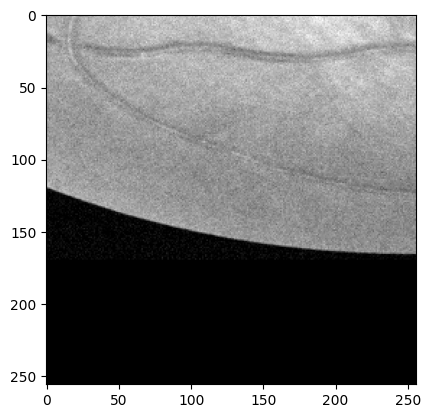

In [ ]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np

# Carica la lista dal file pickle
with open("/content/drive/MyDrive/EIMproject/RETINA/training_pro/Im_1/img_patch_img1_el9.pkl", 'rb') as file:
    lista_patch = pickle.load(file)
#plt.imshow(lista_patch,cmap='gray')
print(np.shape(lista_patch)[0])

# Visualizza ogni numpy array (presumibilmente immagini) nella lista
#
    # Verifica se l'array è un'immagine
    # if len(array.shape) == 3:
        # Se l'array ha 3 dimensioni, potrebbe essere un'immagine (altezza x larghezza x canali)
        # Mostra l'immagine utilizzando matplotlib
plt.figure()
plt.imshow(lista_patch[0,:,:],cmap='gray')
plt.title(f"Numpy Array {idx}")
plt.axis('off')  # Nascondi gli assi
plt.show()
    # else:
    #     print(f"L'array {idx} non è un'immagine e ha {len(array.shape)} dimensioni: {array.shape}")

In [ ]:
import os
import pickle
from tqdm import tqdm
vet=os.listdir("A:\\EIM\\Project_data\\RETINA\\training_pro")

piu_di_1=[]

for i in tqdm(vet):
    with open(os.path.join("A:\\EIM\\Project_data\\RETINA\\training_pro",i), 'rb') as file:
        im = pickle.load(file)
    if im.shape[0]!=1:
        piu_di_1.append(i)

100%|██████████| 346800/346800 [27:53<00:00, 207.19it/s]


In [ ]:
 remove_files("/content/drive/MyDrive/EIMproject/RETINA/training_pro")


In [ ]:
os.listdir("/content/drive/MyDrive/EIMproject/RETINA/training_pro")

[]

In [ ]:
with open("A:\\EIM\\Project_data\\RETINA\\training_pro\\gt_patch_img0_el25.pkl", 'rb') as file:
    gt = torch.from_numpy(pickle.load(file)).float()

In [ ]:
I=Image.open("Project_data\\RETINA\\Original\\1_A.png")
I=np.array(I)
np.max(I)

255